<h3><center>Autoencoder with Attention Mechanism</center></h3>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
import os
os.listdir('/gdrive/My Drive')
path = '/gdrive/My Drive/'

#shiffle marios

In [1]:
#import dependencies
from music21 import *
import mido
import time
import sys
import numpy as np
from tqdm import tqdm_notebook
import tensorflow as tf
import matplotlib.pyplot as plt

tf.enable_eager_execution()

port = mido.open_output()

from keras import backend as K
print (K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


[]


<center> Load and Manipulate Dataset</center>

In [2]:
#load dataset
notes = np.load('../datasets/Piano/notes.npy')
tempos = np.load('../datasets/Piano/tempos.npy')
tpq = np.load('../datasets/Piano/tpq.npy')

In [3]:
#create categorical notes
unique = np.unique(notes)
categorical_to_notes = {(i + 1):o for i, o in enumerate(unique)}
notes_to_categorical = {o:(i + 1) for i, o in enumerate(unique)}

cat_notes = [notes_to_categorical[i] for i in notes]
print (cat_notes[:10])

[1657, 1657, 1823, 1840, 1837, 1831, 1776, 1782, 1823, 1829]


In [4]:
#Define problem Hyperparameters
BATCH_SIZE = 64
vocab_size = max(cat_notes) + 1
seq_length_in = 10
seq_length_out = 10
emb_dim = 50
lstm_cells = 256
print (vocab_size)

2060


In [5]:
def decode_categorical(music):
    notes, durations = [], []
    for i in music:
        raw = categorical_to_notes[i]
        note, duration = raw.split("|")
        notes.append(int(note))
        durations.append(float(duration))
    return notes, durations

def print_progress(c, msg = 'Note: '):
    text = '\r' + msg + " %i"
    sys.stdout.write(text % c)
    sys.stdout.flush()
    
def play_song(notes_music, dur_music, start):
    ticksPerQuarter = tpq[start]
    t = tempos[start]
    counter = 0
    start_time = time.time()
    defaults.ticksPerQuarter = ticksPerQuarter
    for n, d in zip(notes_music, dur_music):
        ticks = midi.translate.durationToMidi(duration.Duration(quarterLength = d))
        real_time = mido.tick2second(ticks, ticksPerQuarter , t)
        time.sleep(real_time)
        msg = mido.Message(type = 'note_on', note = n, velocity = 127)
        port.send(msg)
        counter += 1
        print_progress(counter)

In [6]:
def create_dataset(cat_notes, seq_length_in, seq_length_out):
    input_notes, target_notes = [], []
    for i in (range (len(cat_notes) - seq_length_in - seq_length_out - 10)):
        input_notes.append(cat_notes[i: i + seq_length_in])
        target_notes.append(cat_notes[i + seq_length_in: i + seq_length_in + seq_length_out])
    input_notes = np.array(input_notes)
    target_notes = np.array(target_notes)
    return input_notes, target_notes

In [7]:
input_notes, target_notes = create_dataset(cat_notes, seq_length_in, seq_length_out)

In [8]:
BUFFER_SIZE = len(target_notes)
N_BATCH = BUFFER_SIZE//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((input_notes, target_notes))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

<center>Create Model</center>

In [9]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        print ('Use gru')
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [12]:
encoder = Encoder(vocab_size, emb_dim, lstm_cells, BATCH_SIZE)
decoder = Decoder(vocab_size, emb_dim, lstm_cells, BATCH_SIZE)

In [13]:
optimizer = tf.train.AdamOptimizer()
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [21]:
EPOCHS = 10
get_model()
for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([0] * BATCH_SIZE, 1)       
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables) 
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
            
    # saving (checkpoint) the model every 2 epochs
    if (epoch) % 2 == 0:
        save_model()
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4191


KeyboardInterrupt: 

In [22]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    inputs = sentence.reshape((1, max_length_inp))
    inputs = tf.convert_to_tensor(inputs)
    
    result = []

    hidden = [tf.zeros((1, lstm_cells))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([0], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(predicted_id)
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [23]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [24]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    plot_attention(attention_plot, sentence, result)
    return sentence, result

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: [1657 1657 1823 1840 1837 1831 1776 1782 1823 1829]
Predicted translation: [1731, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706, 1776, 1782, 1722, 1728, 1700, 1706,

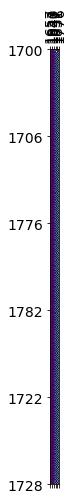

In [27]:
get_model()
sentence , result  = translate(input_notes[0], encoder, decoder, categorical_to_notes, notes_to_categorical, seq_length_in, 500)

In [28]:
n, d = decode_categorical(result)
note, dur = decode_categorical(list(sentence))
note.append(n)
dur.append(dur)
play_song(n, d, 0)

Note:  380

KeyboardInterrupt: 

In [15]:
import pickle
def save_model():
    enc = encoder.get_weights()
    dec = decoder.get_weights()
    with open("enc.txt", "wb") as fp:   #Pickling
        pickle.dump(enc, fp)
    with open("dec.txt", "wb") as fp:   #Pickling
        pickle.dump(dec, fp)

In [16]:
def get_model():
    with open("enc.txt", "rb") as fp:   # Unpickling
        enc = pickle.load(fp)
    with open("dec.txt", "rb") as fp:   # Unpickling
        dec = pickle.load(fp)
    encoder.set_weights(enc)
    decoder.set_weights(dec)

In [18]:
get_model()
encoder.get_weights()

[array([[ 0.01138427, -0.00477556, -0.04870009, ...,  0.00870353,
          0.01666996, -0.00804508],
        [-0.08304866, -0.10681354,  0.29818234, ...,  0.05513756,
          0.03887966,  0.7497675 ],
        [-0.6426817 , -0.42611003,  0.4795537 , ..., -0.10128858,
         -0.01337141,  0.590566  ],
        ...,
        [ 1.0789005 , -0.4403345 , -0.5063783 , ...,  0.15429148,
          0.00603014,  1.223402  ],
        [-1.3664311 ,  0.11533833, -0.31420463, ...,  0.53394186,
          0.02881997, -0.4393255 ],
        [-0.16498746,  0.05752696, -0.82576275, ...,  0.62147313,
          0.14719737,  0.7034655 ]], dtype=float32),
 array([[-1.06040502e+00,  1.20885596e-01, -5.82239591e-02, ...,
          3.93261686e-02, -5.74423932e-02,  4.96827066e-03],
        [-5.22974670e-01, -6.15277886e-01, -2.69292146e-01, ...,
         -3.13647062e-01, -1.87747017e-01, -2.27545142e-01],
        [ 2.60344595e-01, -3.18076342e-01,  7.75720254e-02, ...,
         -2.82554757e-02,  1.01173267e-01

In [19]:
with open("enc.txt", "rb") as fp:   # Unpickling
        enc = pickle.load(fp)

In [20]:
enc

[array([[ 0.01138427, -0.00477556, -0.04870009, ...,  0.00870353,
          0.01666996, -0.00804508],
        [-0.08304866, -0.10681354,  0.29818234, ...,  0.05513756,
          0.03887966,  0.7497675 ],
        [-0.6426817 , -0.42611003,  0.4795537 , ..., -0.10128858,
         -0.01337141,  0.590566  ],
        ...,
        [ 1.0789005 , -0.4403345 , -0.5063783 , ...,  0.15429148,
          0.00603014,  1.223402  ],
        [-1.3664311 ,  0.11533833, -0.31420463, ...,  0.53394186,
          0.02881997, -0.4393255 ],
        [-0.16498746,  0.05752696, -0.82576275, ...,  0.62147313,
          0.14719737,  0.7034655 ]], dtype=float32),
 array([[-1.06040502e+00,  1.20885596e-01, -5.82239591e-02, ...,
          3.93261686e-02, -5.74423932e-02,  4.96827066e-03],
        [-5.22974670e-01, -6.15277886e-01, -2.69292146e-01, ...,
         -3.13647062e-01, -1.87747017e-01, -2.27545142e-01],
        [ 2.60344595e-01, -3.18076342e-01,  7.75720254e-02, ...,
         -2.82554757e-02,  1.01173267e-01

In [ ]:
encoder.get_weights()